In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
import tensorflow.keras.backend as K

In [2]:
# load data 
MPSA_data = mavenn.load_example(which='training_data',name='mpsa')
MPSA_data.head()

,x,y
0,TAAGCTTTA,-3.455265
1,GCAGCCTAT,-3.135494
2,GTGGTAAGG,2.291043
3,TGGGCGCAG,-3.147840
4,GGTGCGGGC,0.547527


In [3]:
x_train = MPSA_data['x'].values
y_train = MPSA_data['y'].values

In [4]:
# load mavenn's GE model
gpmap_type = 'neighbor'
ge_noise_model_type = 'SkewedT'
GER = mavenn.Model(regression_type='GE',
                   x=x_train,
                   y=y_train,
                   gpmap_type=gpmap_type,
                   ge_noise_model_type=ge_noise_model_type,
                   ge_nonlinearity_monotonic=True,
                   alphabet='dna',
                   ge_heteroskedasticity_order=2,
                   theta_regularization=0.01,
                   eta_regularization=0.01)

In [5]:
GER.model.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_labels_input (InputLay [(None, 165)]        0                                            
__________________________________________________________________________________________________
Sequence_only (Lambda)          (None, 164)          0           Sequence_labels_input[0][0]      
__________________________________________________________________________________________________
phi (Dense)                     (None, 1)            165         Sequence_only[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           100         phi[0][0]                        
_______________________________________________________________________________________

In [6]:
GER.fit(epochs=40,
        learning_rate=0.005,
        early_stopping=False,
        early_stopping_patience=5,
        validation_split=0.1,
        verbose=True)

# make predictions on held out test set

# predictions = GER.predict(x_test)

Epoch 1/40
297/297 [==============================] - 1s 2ms/step - loss: 143.9343 - val_loss: 122.7048
Epoch 2/40
297/297 [==============================] - 0s 1ms/step - loss: 96.3348 - val_loss: 66.7831
Epoch 3/40
297/297 [==============================] - 0s 1ms/step - loss: 60.8982 - val_loss: 57.9859
Epoch 4/40
297/297 [==============================] - 0s 1ms/step - loss: 55.6986 - val_loss: 47.7632
Epoch 5/40
297/297 [==============================] - 0s 1ms/step - loss: 49.2547 - val_loss: 45.9981
Epoch 6/40
297/297 [==============================] - 0s 1ms/step - loss: 48.5826 - val_loss: 46.2407
Epoch 7/40
297/297 [==============================] - 0s 1ms/step - loss: 48.4104 - val_loss: 45.6951
Epoch 8/40
297/297 [==============================] - 0s 1ms/step - loss: 47.9243 - val_loss: 45.5643
Epoch 9/40
297/297 [==============================] - 0s 1ms/step - loss: 47.3442 - val_loss: 43.9418
Epoch 10/40
297/297 [==============================] - 0s 1ms/step - loss: 46.23

In [7]:
loss_history = GER.model.history

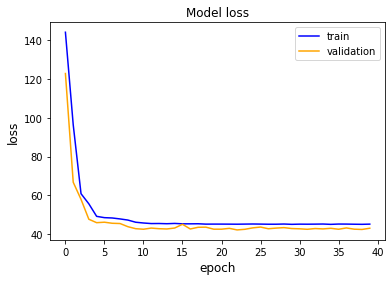

In [8]:
plt.plot(loss_history.history['loss'], color='blue')
plt.plot(loss_history.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])

In [9]:
MPSA_data_test = mavenn.load_example(which='test_data',name='mpsa')
x_test = MPSA_data_test['x'].values
y_test = MPSA_data_test['y'].values

In [10]:
yhat = GER.x_to_yhat(x_test)
phi = GER.x_to_phi(x_test)


In [11]:
phi_range = np.linspace(min(phi),max(phi),1000)

In [12]:
model = GER.get_nn()

In [13]:
# predictions
yhat = GER.x_to_yhat(x_test)

# evaluate phi for sequences 
phi = GER.x_to_phi(x_test)

# equalate g(phi) for continuous phi
phi_range = np.linspace(min(phi),max(phi),1000)
y_hat_GE = GER.phi_to_yhat(phi_range)

# noise model that is used to get eta parameters
#qs = GER.yhat_to_yq(y_hat_GE,q=[0.16,0.84])
qs = GER.yhat_to_yq(y_hat_GE,q=np.array([0.16,0.84]))

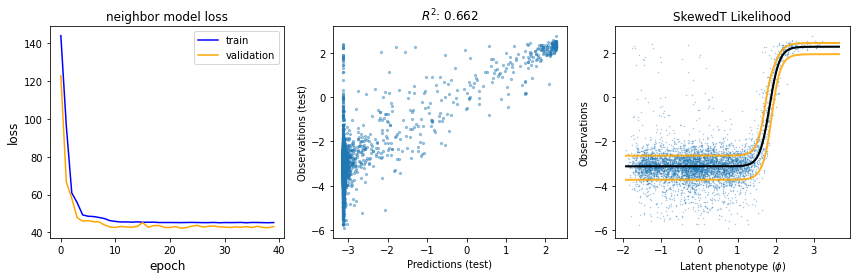

In [14]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

ax[0].plot(loss_history.history['loss'], color='blue')
ax[0].plot(loss_history.history['val_loss'], color='orange')
ax[0].set_title(GER.gpmap_type+' model loss', fontsize=12)
ax[0].set_ylabel('loss', fontsize=12)
ax[0].set_xlabel('epoch', fontsize=12)
ax[0].legend(['train', 'validation'])

Rsq = np.corrcoef(yhat.ravel(),y_test)[0][1]**2
ax[1].scatter(yhat,y_test,s=5,alpha=0.4)
ax[1].set_xlabel('Predictions (test)')
ax[1].set_ylabel('Observations (test)')
ax[1].set_title('$R^2$: '+str(Rsq)[0:5])

ax[2].plot(phi_range,GER.phi_to_yhat(phi_range))
ax[2].scatter(phi,y_test,s=0.25, alpha=0.4, label='Observations')
ax[2].plot(phi_range,GER.phi_to_yhat(phi_range),lw=2,label='$\hat{y}$',alpha=1.0,color='black')

for q_index in range(qs.shape[1]):
    ax[2].plot(phi_range,qs[:,q_index].ravel(),color='orange',lw=2,alpha=0.85,label='$\hat{y} \pm \sigma(\hat{y})$')

ax[2].set_ylabel('Observations')
ax[2].set_xlabel('Latent phenotype ($\phi$)')
ax[2].set_title(GER.ge_noise_model_type+' Likelihood')

# ax[2].scatter(y_test,GER._p_of_y_given_y_hat(y_test,0.1))
# ax[2].set_ylabel('$P(y|\hat{y}=0.1)$')
# ax[2].set_xlabel('y (test values)')

plt.tight_layout()
plt.show()

In [15]:
#GER.save('mpsa_ge_neighbor')